Epoch 1/25, Training Loss: 0.0074, Training SSIM: 0.6681, Validation Loss: 0.0016, Validation Accuracy: 0.7881
Epoch 2/25, Training Loss: 0.0012, Training SSIM: 0.8227, Validation Loss: 0.0010, Validation Accuracy: 0.8508
Epoch 3/25, Training Loss: 0.0008, Training SSIM: 0.8678, Validation Loss: 0.0007, Validation Accuracy: 0.8870
Epoch 4/25, Training Loss: 0.0006, Training SSIM: 0.8944, Validation Loss: 0.0006, Validation Accuracy: 0.9029
Epoch 5/25, Training Loss: 0.0005, Training SSIM: 0.9038, Validation Loss: 0.0005, Validation Accuracy: 0.9085
Epoch 6/25, Training Loss: 0.0005, Training SSIM: 0.9091, Validation Loss: 0.0005, Validation Accuracy: 0.9136
Epoch 7/25, Training Loss: 0.0005, Training SSIM: 0.9135, Validation Loss: 0.0004, Validation Accuracy: 0.9180
Epoch 8/25, Training Loss: 0.0005, Training SSIM: 0.9182, Validation Loss: 0.0005, Validation Accuracy: 0.9217
Epoch 9/25, Training Loss: 0.0004, Training SSIM: 0.9226, Validation Loss: 0.0004, Validation Accuracy: 0.9264
E

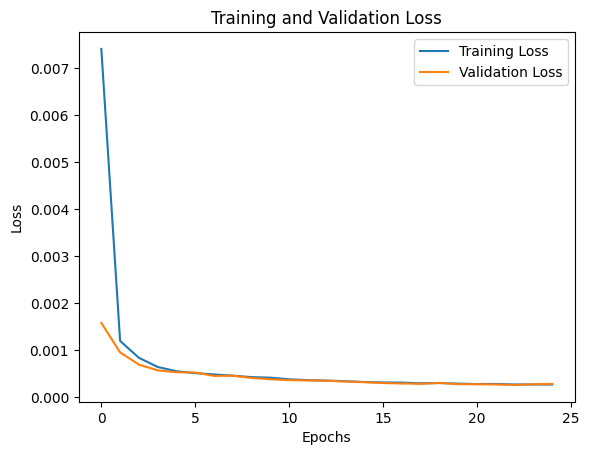

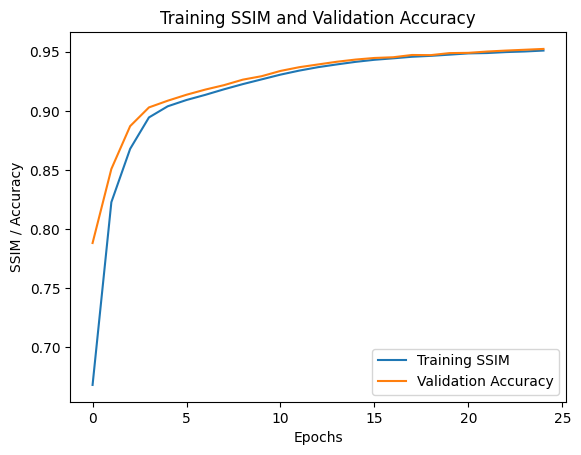

In [ ]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader, random_split
from PIL import Image
import matplotlib.pyplot as plt
from pytorch_msssim import ssim

# Constants
IMG_SIZE = 60
BATCH_SIZE = 32
VALIDATION_SPLIT = 0.2
NUM_EPOCHS = 25
LEARNING_RATE = 0.001  # Reduced learning rate for smoother convergence
NUM_CLASSES = 400

# Dataset class
class IrisDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_paths = [os.path.join(dp, f) for dp, dn, filenames in os.walk(root_dir) for f in filenames if f.endswith('.jpg')]

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('L')
        if self.transform:
            image = self.transform(image)
        return image

# Transform
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Autoencoder definition
class SimpleConvAutoencoder(nn.Module):
    def __init__(self):
        super(SimpleConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(32, 64, 2, stride=2),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 1, 2, stride=2),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

# Loss class
class OpenSetLoss(nn.Module):
    def __init__(self):
        super(OpenSetLoss, self).__init__()

    def forward(self, outputs, targets):
        return F.mse_loss(outputs, targets)

# Dataset and DataLoader initialization
dataset = IrisDataset('/kaggle/input/twinss', transform=transform)
train_size = int((1 - VALIDATION_SPLIT) * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Model, loss, and optimizer
model = SimpleConvAutoencoder()
criterion = OpenSetLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

# Training and validation
train_losses, val_losses, train_ssim, val_accuracy = [], [], [], []

for epoch in range(NUM_EPOCHS):
    model.train()
    train_loss, train_s = 0.0, 0.0
    for images in train_loader:
        images = images.float()
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, images)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        train_s += ssim(outputs, images, data_range=1, size_average=True).item() * images.size(0)
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_s /= len(train_loader.dataset)
    train_ssim.append(train_s)

    model.eval()
    val_loss, val_acc = 0.0, 0.0
    with torch.no_grad():
        for images in val_loader:
            images = images.float()
            outputs = model(images)
            loss = criterion(outputs, images)
            val_loss += loss.item() * images.size(0)
            val_acc += ssim(outputs, images, data_range=1, size_average=True).item() * images.size(0)
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_acc /= len(val_loader.dataset)
    val_accuracy.append(val_acc)

    print(f'Epoch {epoch+1}/{NUM_EPOCHS}, Training Loss: {train_loss:.4f}, Training SSIM: {train_s:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}')

# Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_ssim, label='Training SSIM')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training SSIM and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('SSIM / Accuracy')
plt.legend()
plt.show()

# Save model
torch.save(model.state_dict(), 'model.pth')


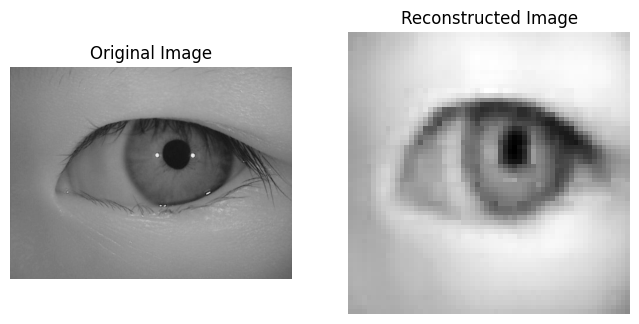

In [ ]:
import torch
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt

# Constants
IMG_SIZE = 60

# Load the trained model
class SimpleConvAutoencoder(torch.nn.Module):
    def __init__(self):
        super(SimpleConvAutoencoder, self).__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1, 64, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
            torch.nn.Conv2d(64, 32, 3, padding=1),
            torch.nn.ReLU(),
            torch.nn.MaxPool2d(2),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.ConvTranspose2d(32, 64, 2, stride=2),
            torch.nn.ReLU(),
            torch.nn.ConvTranspose2d(64, 1, 2, stride=2),
            torch.nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = SimpleConvAutoencoder()
model.load_state_dict(torch.load('model.pth'))
model.eval()

# Define the transformation
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor()
])

# Function to reconstruct and plot images
def reconstruct_and_plot(image_path):
    image = Image.open(image_path).convert('L')
    tensor = transform(image).unsqueeze(0)
    with torch.no_grad():
        reconstructed_image = model(tensor)
    reconstructed_image = reconstructed_image.squeeze().numpy()

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(reconstructed_image, cmap='gray')
    plt.title('Reconstructed Image')
    plt.axis('off')

    plt.show()

# Test on a sample image
image_path = '/kaggle/input/twinss/00/2R/S3002R01.jpg'  # Path to your sample image
reconstruct_and_plot(image_path)


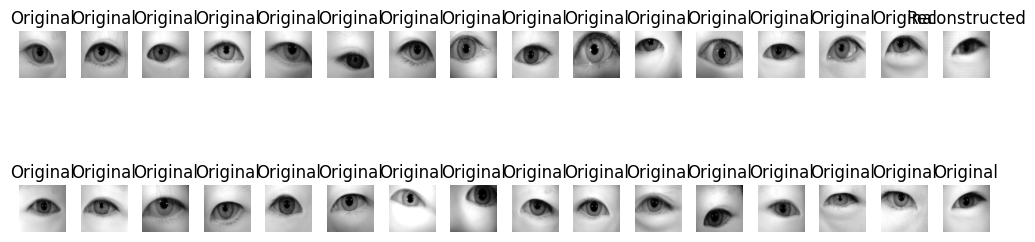

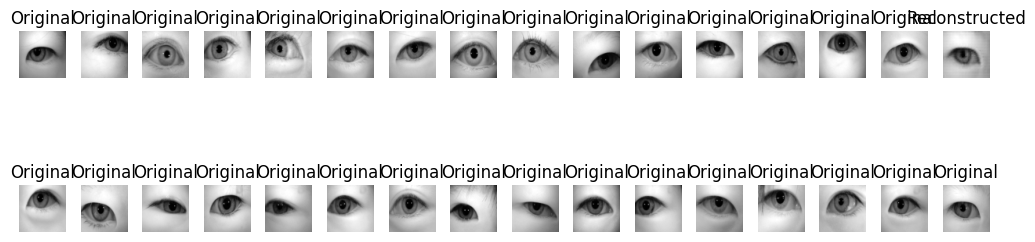

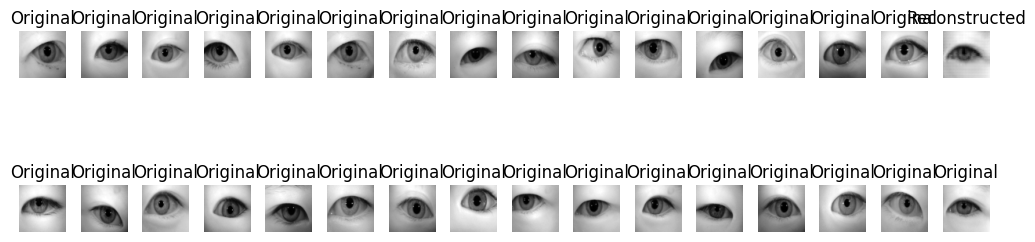

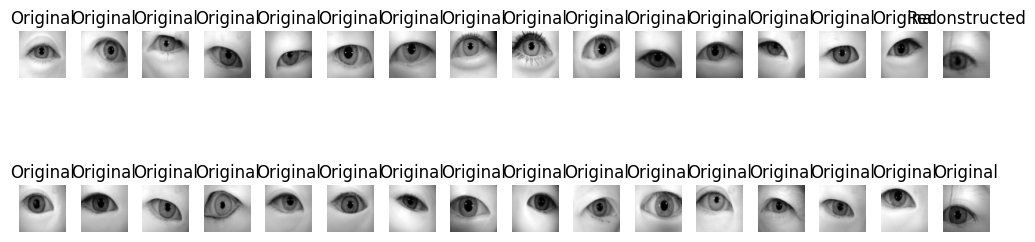

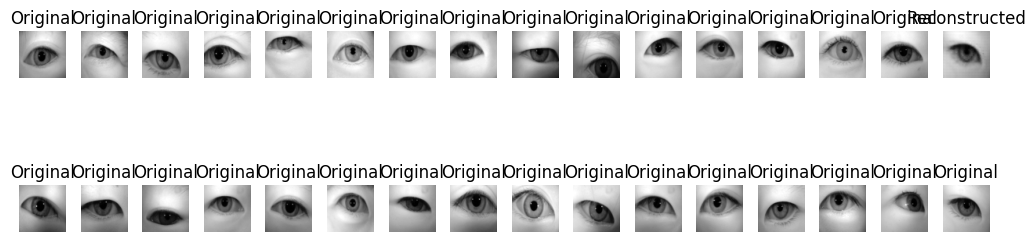

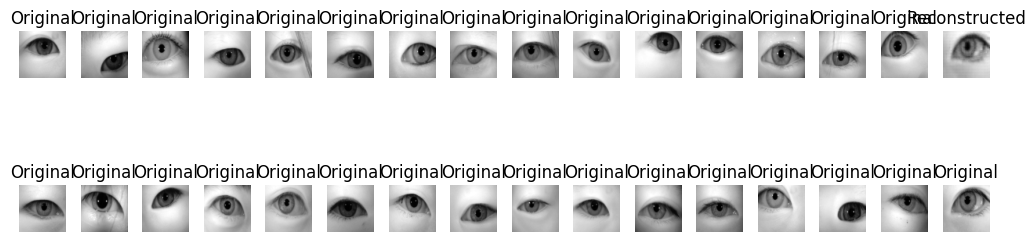

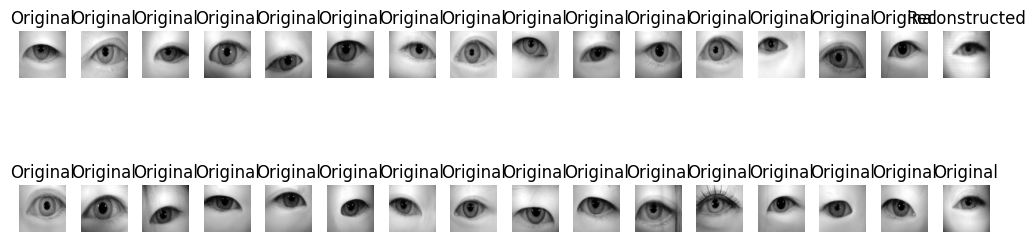

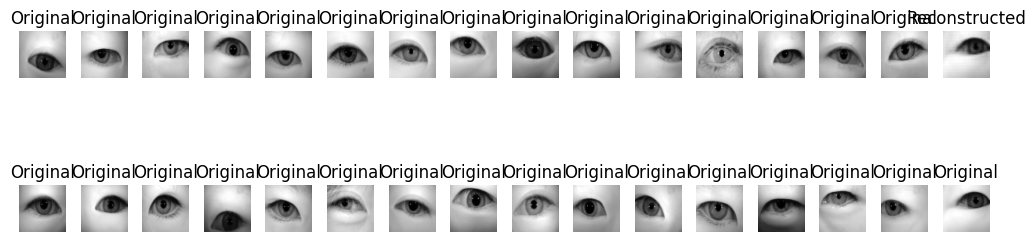

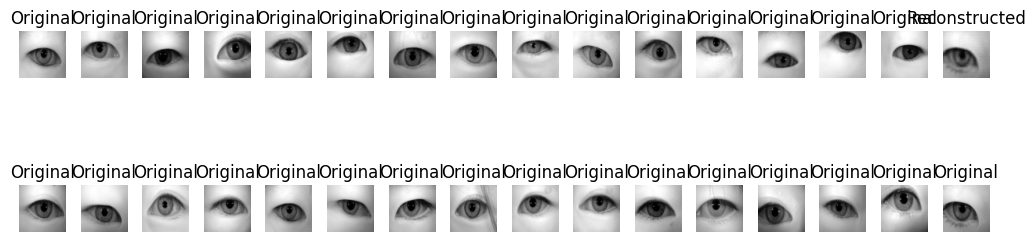

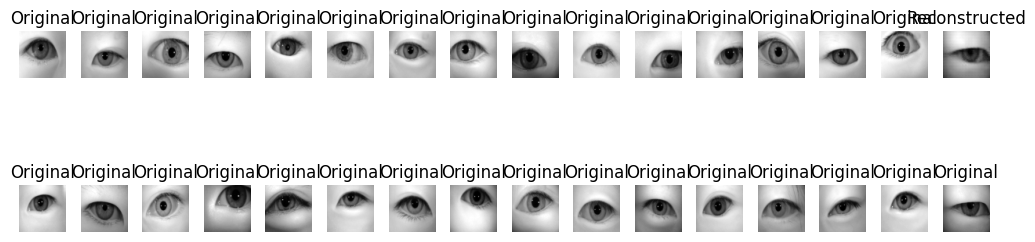

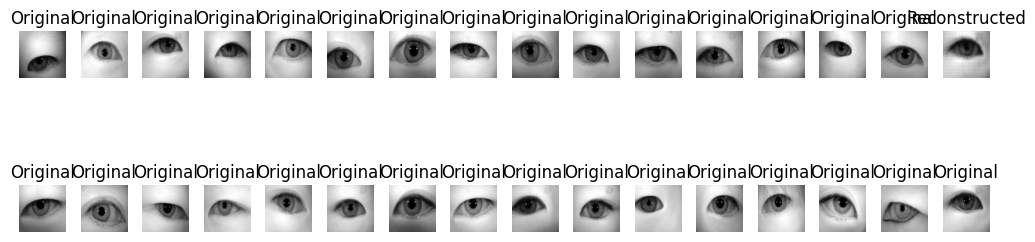

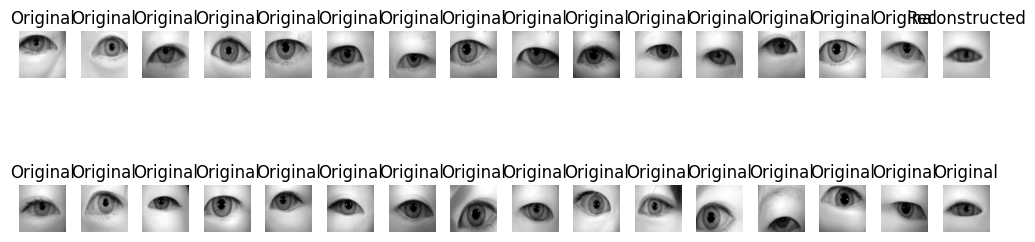

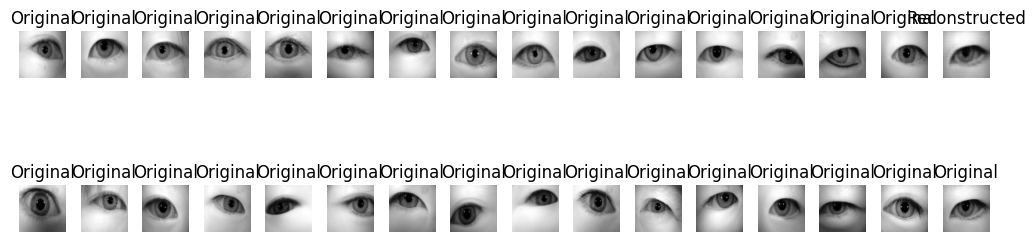

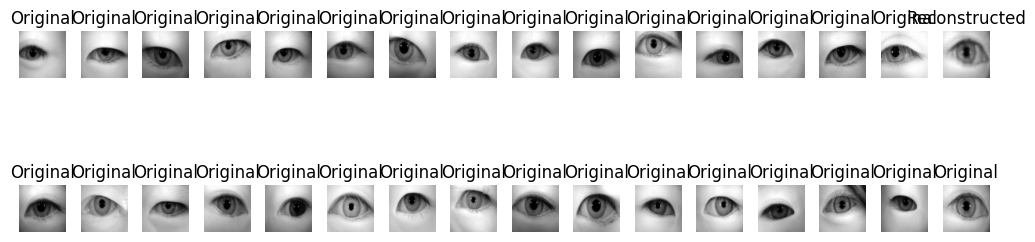

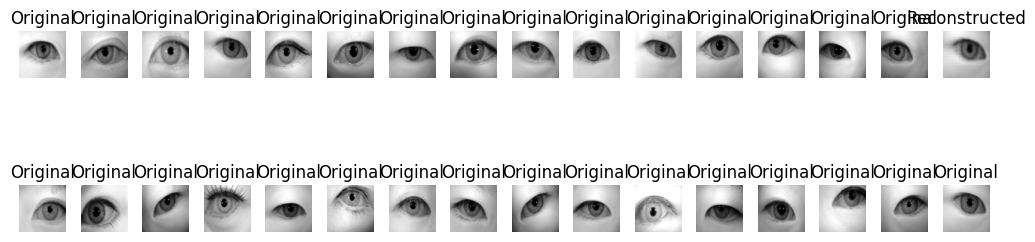

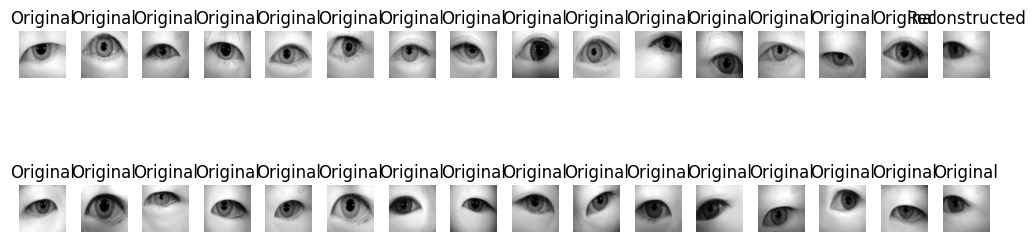

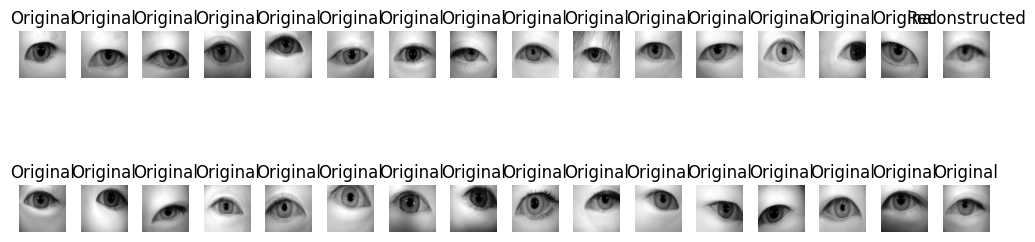

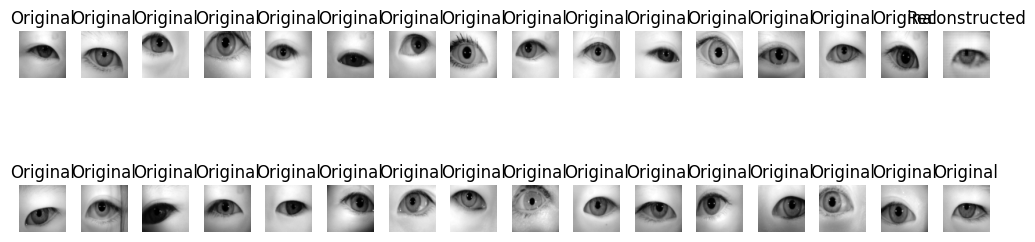

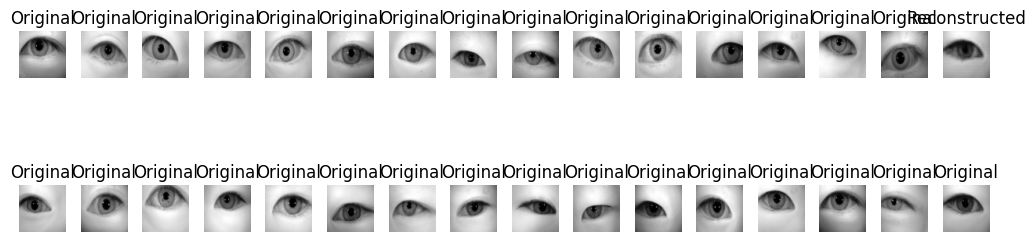

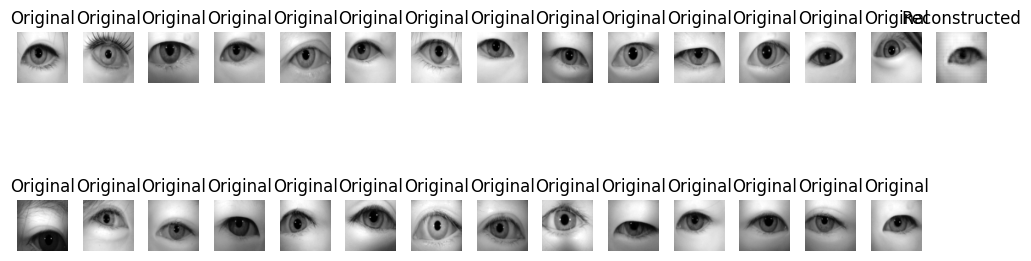

In [ ]:
def reconstruct_and_plot(batch_images):
    batch_size = len(batch_images)
    num_rows = 2
    # Adjusting for odd batch size and adding 1 for subplot indexing
    num_cols = min((batch_size + 1) // num_rows, batch_size)
    plt.figure(figsize=(10, 4))
    for i in range(batch_size):
        plt.subplot(num_rows, num_cols, i+1)
        plt.imshow(batch_images[i].squeeze().numpy(), cmap='gray')
        plt.title('Original')
        plt.axis('off')

    with torch.no_grad():
        reconstructed_images = model(batch_images)
    reconstructed_images = reconstructed_images.squeeze().numpy()
    for i in range(batch_size):
        plt.subplot(num_rows, num_cols, min(num_cols, num_cols + i + 1))
        plt.imshow(reconstructed_images[i], cmap='gray')
        plt.title('Reconstructed')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

for batch_images in val_loader:
    reconstruct_and_plot(batch_images)


Testing Accuracy: 0.9464


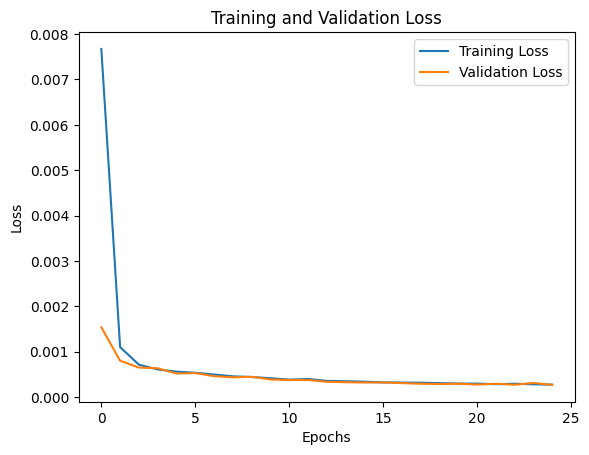

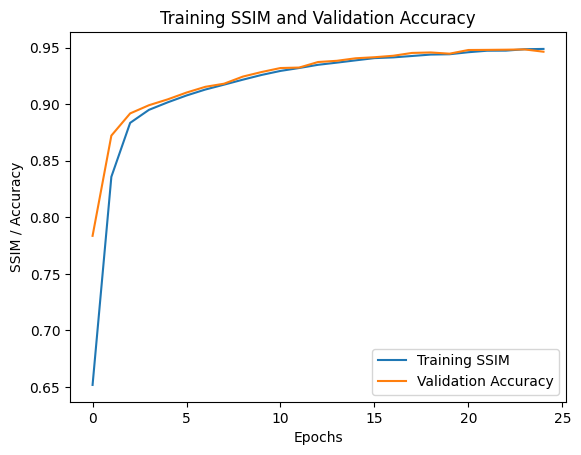

In [ ]:
# Testing
test_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

test_accuracy = 0.0
with torch.no_grad():
    for images in test_loader:
        images = images.float()
        outputs = model(images)
        test_accuracy += ssim(outputs, images, data_range=1, size_average=True).item() * images.size(0)
test_accuracy /= len(test_loader.dataset)
print(f'Testing Accuracy: {test_accuracy:.4f}')

# Plotting
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(train_ssim, label='Training SSIM')
plt.plot(val_accuracy, label='Validation Accuracy')
plt.title('Training SSIM and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('SSIM / Accuracy')
plt.legend()
plt.show()

# Save model
torch.save(model.state_dict(), 'model.pth')